In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
import os
from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper, provideData
from Utils.transform import ToCategorical, cutOut
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (128,128)
channels = 7
optimizer = Adam( lr = 1e-3 )
slices = [224,352,224,352]
slices_label = [32,64+32,32,64+32]
cutOutFrame = cutOut(slices)
cutOutFrame_label = cutOut(slices_label)
years = [2015,2016,2017]
PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATION = [cutOutFrame_label]
batch_size = 250

train, test = provideData(dimension=dimension,
                          batch_size=batch_size,
                          channels = channels,
                          timeToPred = 30,
                          fillSteps = True,
                          year = years,
                          transform=TRANSFORMATION,
                          preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2015 => won't download this year again... please check for consistency
Found Year :  2016 => won't download this year again... please check for consistency
Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 
[DEBUG] Data
[DEBUG] time to predict:  30
[DEBUG] Data
[DEBUG] time to predict:  30


In [3]:
def negative_Binomial_Unet_128x128IN_FULLOUT(input_shape,
                           activation_hidden="relu",
                           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up01 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    #up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    #up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64
    
    
    output = Conv2D(12, (1, 1), activation="softplus")(up01)  # 1 x 64x64
    
    shape = tf.shape(output)
    shape = output.shape
    output = MaxPooling2D((2, 2), strides=(2, 2))(output)
    output = Conv2D(12, (1, 1), activation="softplus")(output)
    output = MaxPooling2D((2, 2), strides=(2, 2))(output)
    print(shape)
    
    max_count = output[:,:,:,:6]
    prob      = output[:,:,:,6:]
    max_count = Flatten()(max_count)
    prob      = Flatten()(prob)
    prob      = Dense(16*16)(prob)
    prob      = Dropout(0.1)(prob)
    
    max_count      = Dense(16*16)(max_count)
    max_count      = Dropout(0.1)(max_count)
    
    prob      = Dense(64*64*6,activation="sigmoid")(prob)
    max_count = Dense(64*64*6,activation=tf.keras.activations.softplus)(max_count)
    prob      = tf.keras.layers.Reshape((64,64,6))(prob)
    max_count = tf.keras.layers.Reshape((64,64,6))(max_count)
    input_dist= tf.concat([max_count,prob],axis=-1)
    
    output_dist = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Independent(tfp.distributions.NegativeBinomial(
            total_count=t[..., :6], probs=t[..., 6:] ),
            reinterpreted_batch_ndims=3
    ))

    
    output = output_dist(input_dist)
    model = Model(inputs=inputs, outputs=output)
    return model

In [4]:
trainer = Trainer(negative_Binomial_Unet_128x128IN_FULLOUT,
                    lossfunction=NLL,
                    pathToData=(train,test),
                    batch_size = batch_size,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

(None, 64, 64, 12)
[Loaded file]  ./model_data/negative_Binomial_Unet_128x128IN_FULLOUT_function/negative_Binomial_Unet_128x128IN_FULLOUT_function128x128x7.h5
5
[Loaded file]  ./model_data/negative_Binomial_Unet_128x128IN_FULLOUT_function/negative_Binomial_Unet_128x128IN_FULLOUT_function128x128x7history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 7) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 10) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 10) 0           conv2d[0][0]    

In [5]:
#trainer.fit(5)

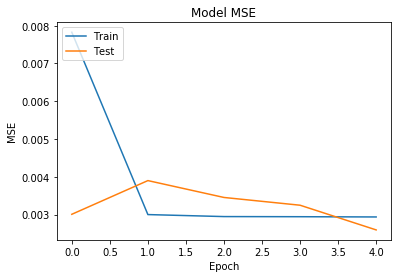

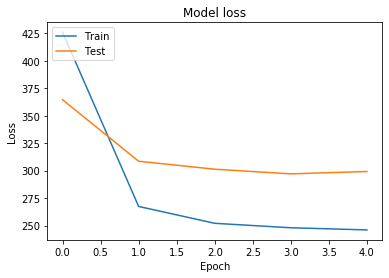

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = trainer.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

In [10]:
test.on_epoch_end()
model      = trainer.model
pred       = None
label      = None
pred_      = 40
mean       = []
stdev      = []
label      = []
prediction = []
input_vals = []
for ctr,(x,y) in enumerate(test):
    if ctr > pred_:
        break
    for i in range(batch_size):
        pred = model(np.array([x[i,:,:,:]]))
        prediction.append(pred)
        label.append(y[i,:,:,:])
        input_vals.append(x[i,:,:,:])


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:108: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


In [11]:
def simpleBaseline(inp,label):
    x,y,t      = label[0].shape
    rain_true  = np.zeros((x,y,t))
    rain_false = rain_true.copy()
    
    for i in range(len(label)):
        present = inp[i][:,:,-1]
        timesteps_pred = []
        
        x_min,y_min = 0,0
        x_max,y_max = present.shape[:2]
        
        if y < present.shape[1]:
            offset = present.shape[0] // 2
            y_min += offset
            y_max += offset
            x_min += offset
            x_max += offset
            
        for j in range(t):
            l = label[i][:,:,j]
            p = present[x_min:x_max,y_min:y_max]
            
            #l[np.where(l > 0)] = 1
            #p[np.where(p > 0)] = 1
            mask = (l == p)
            rain_true[:,:,j] += mask
            rain_false[:,:,j] += ~mask
            
    return rain_true,rain_false
        
        
rain_simple = simpleBaseline(input_vals,label)

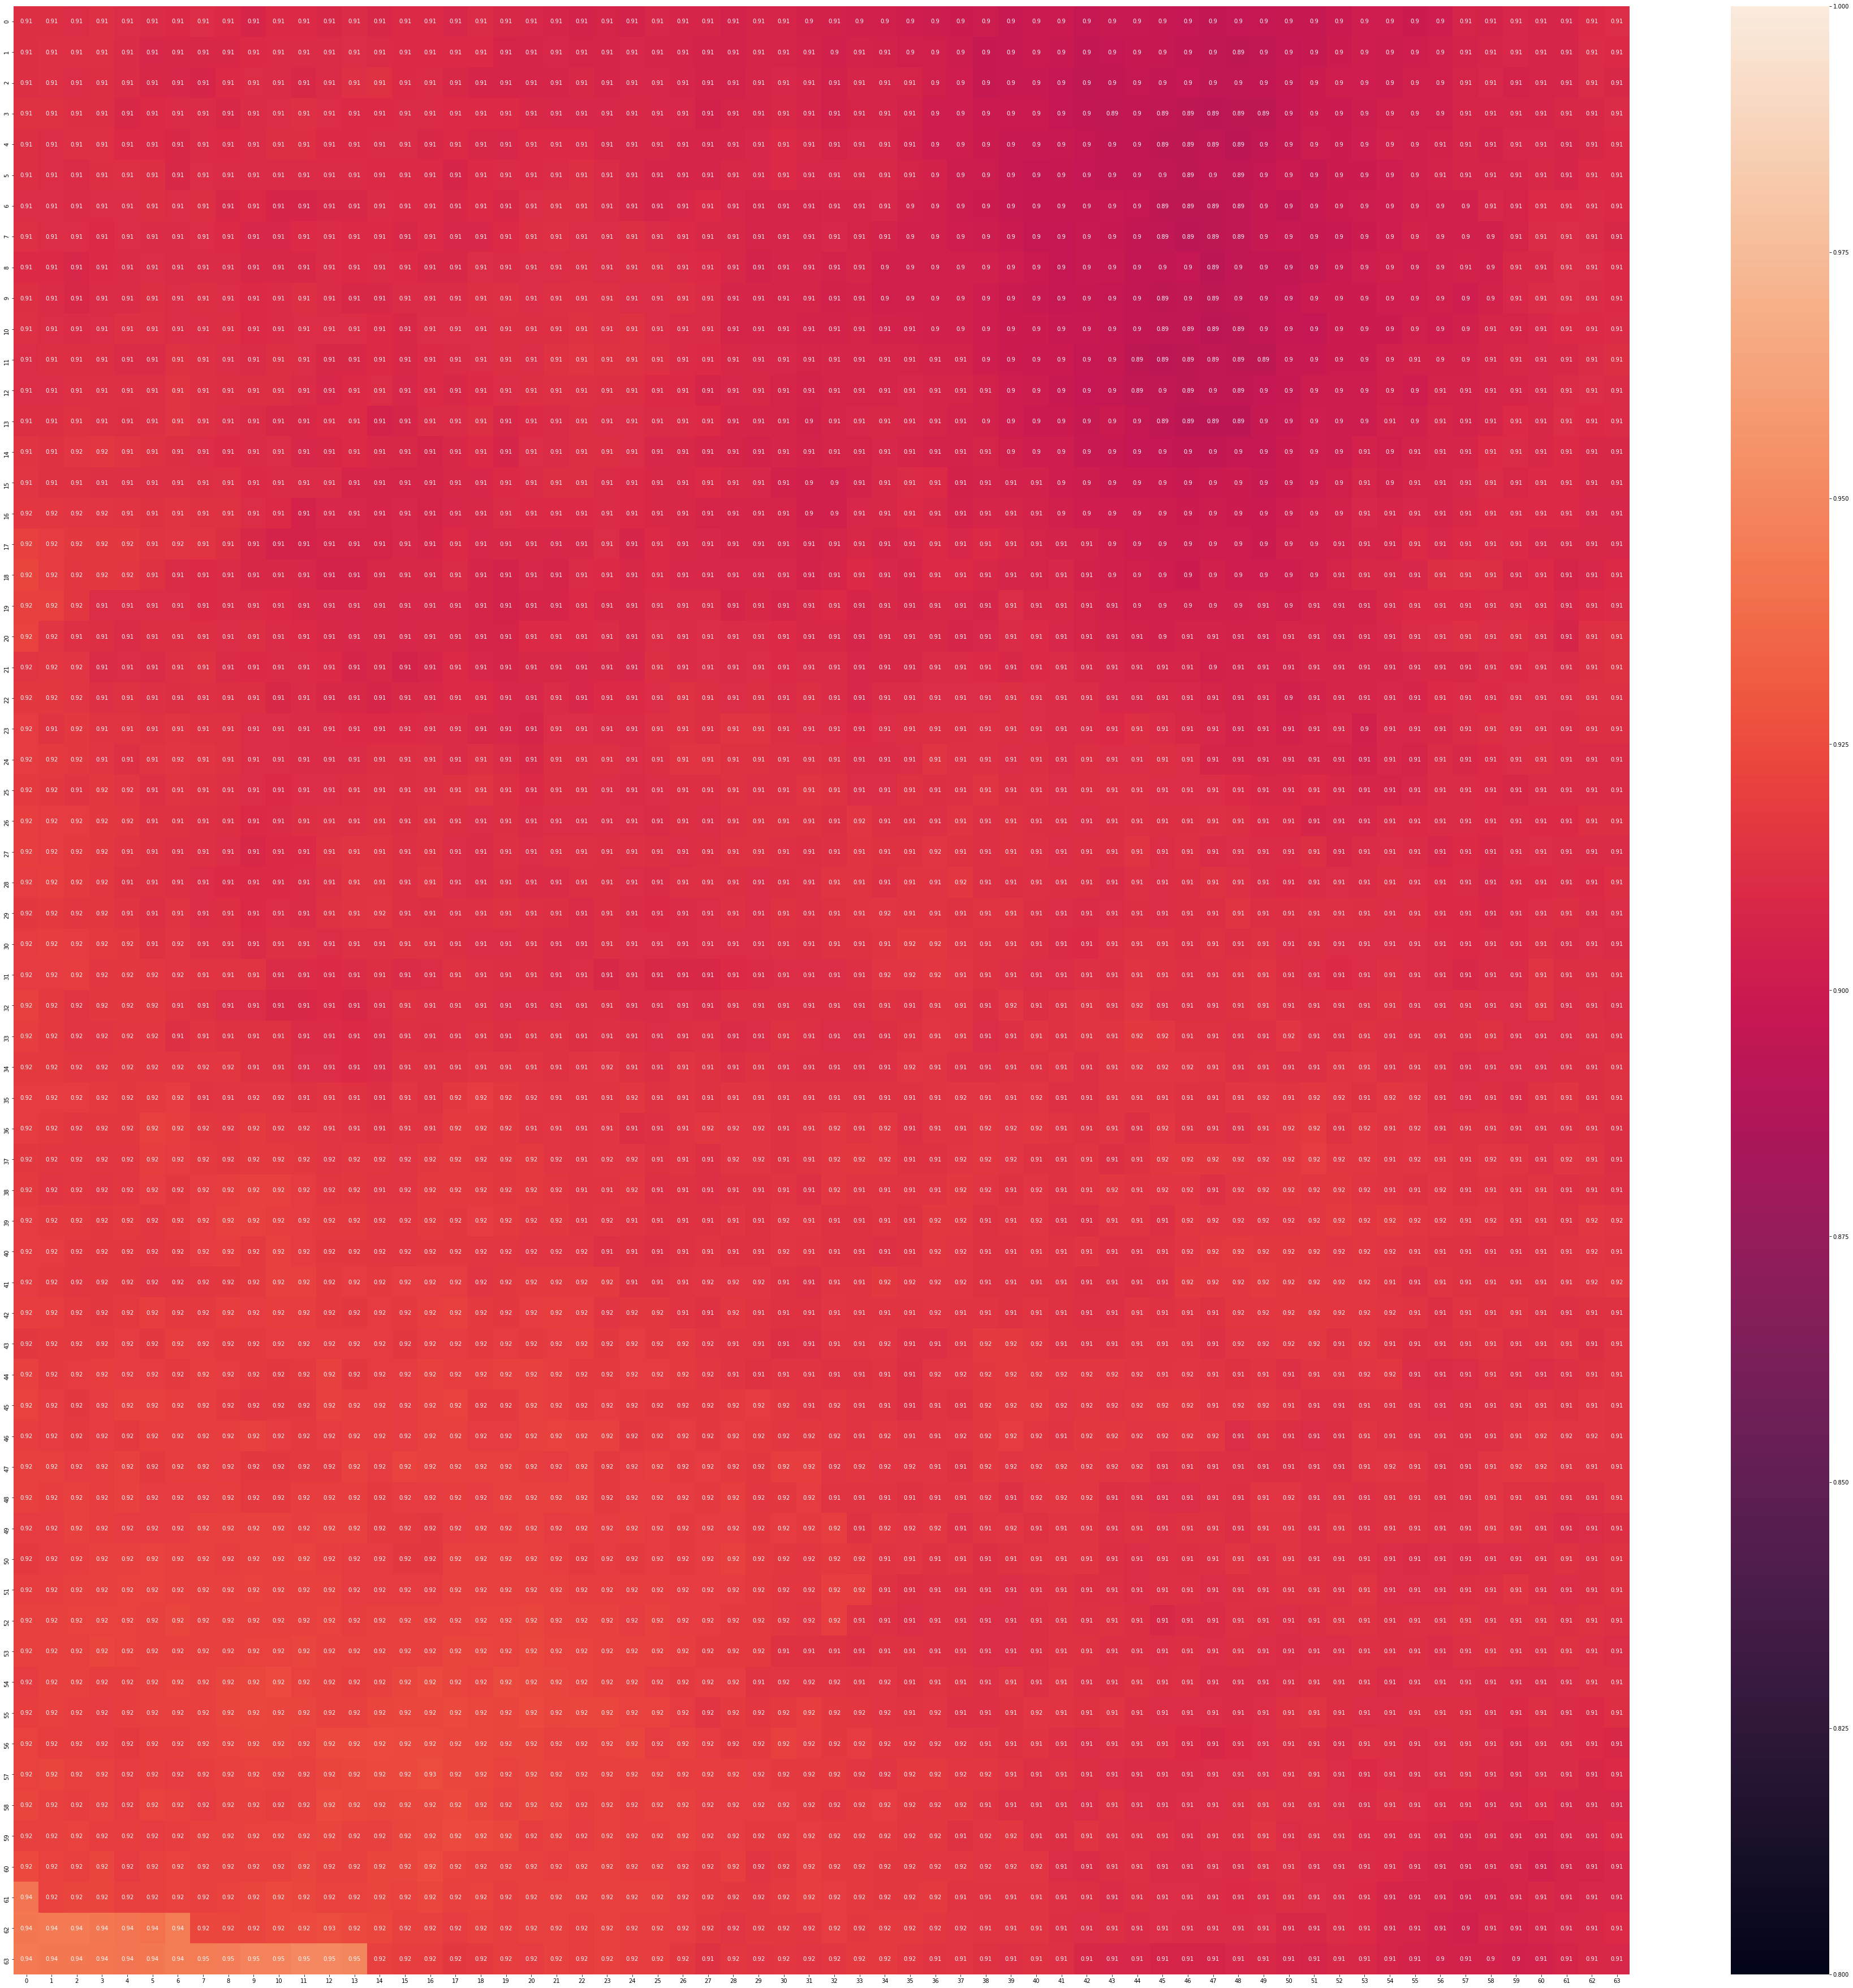

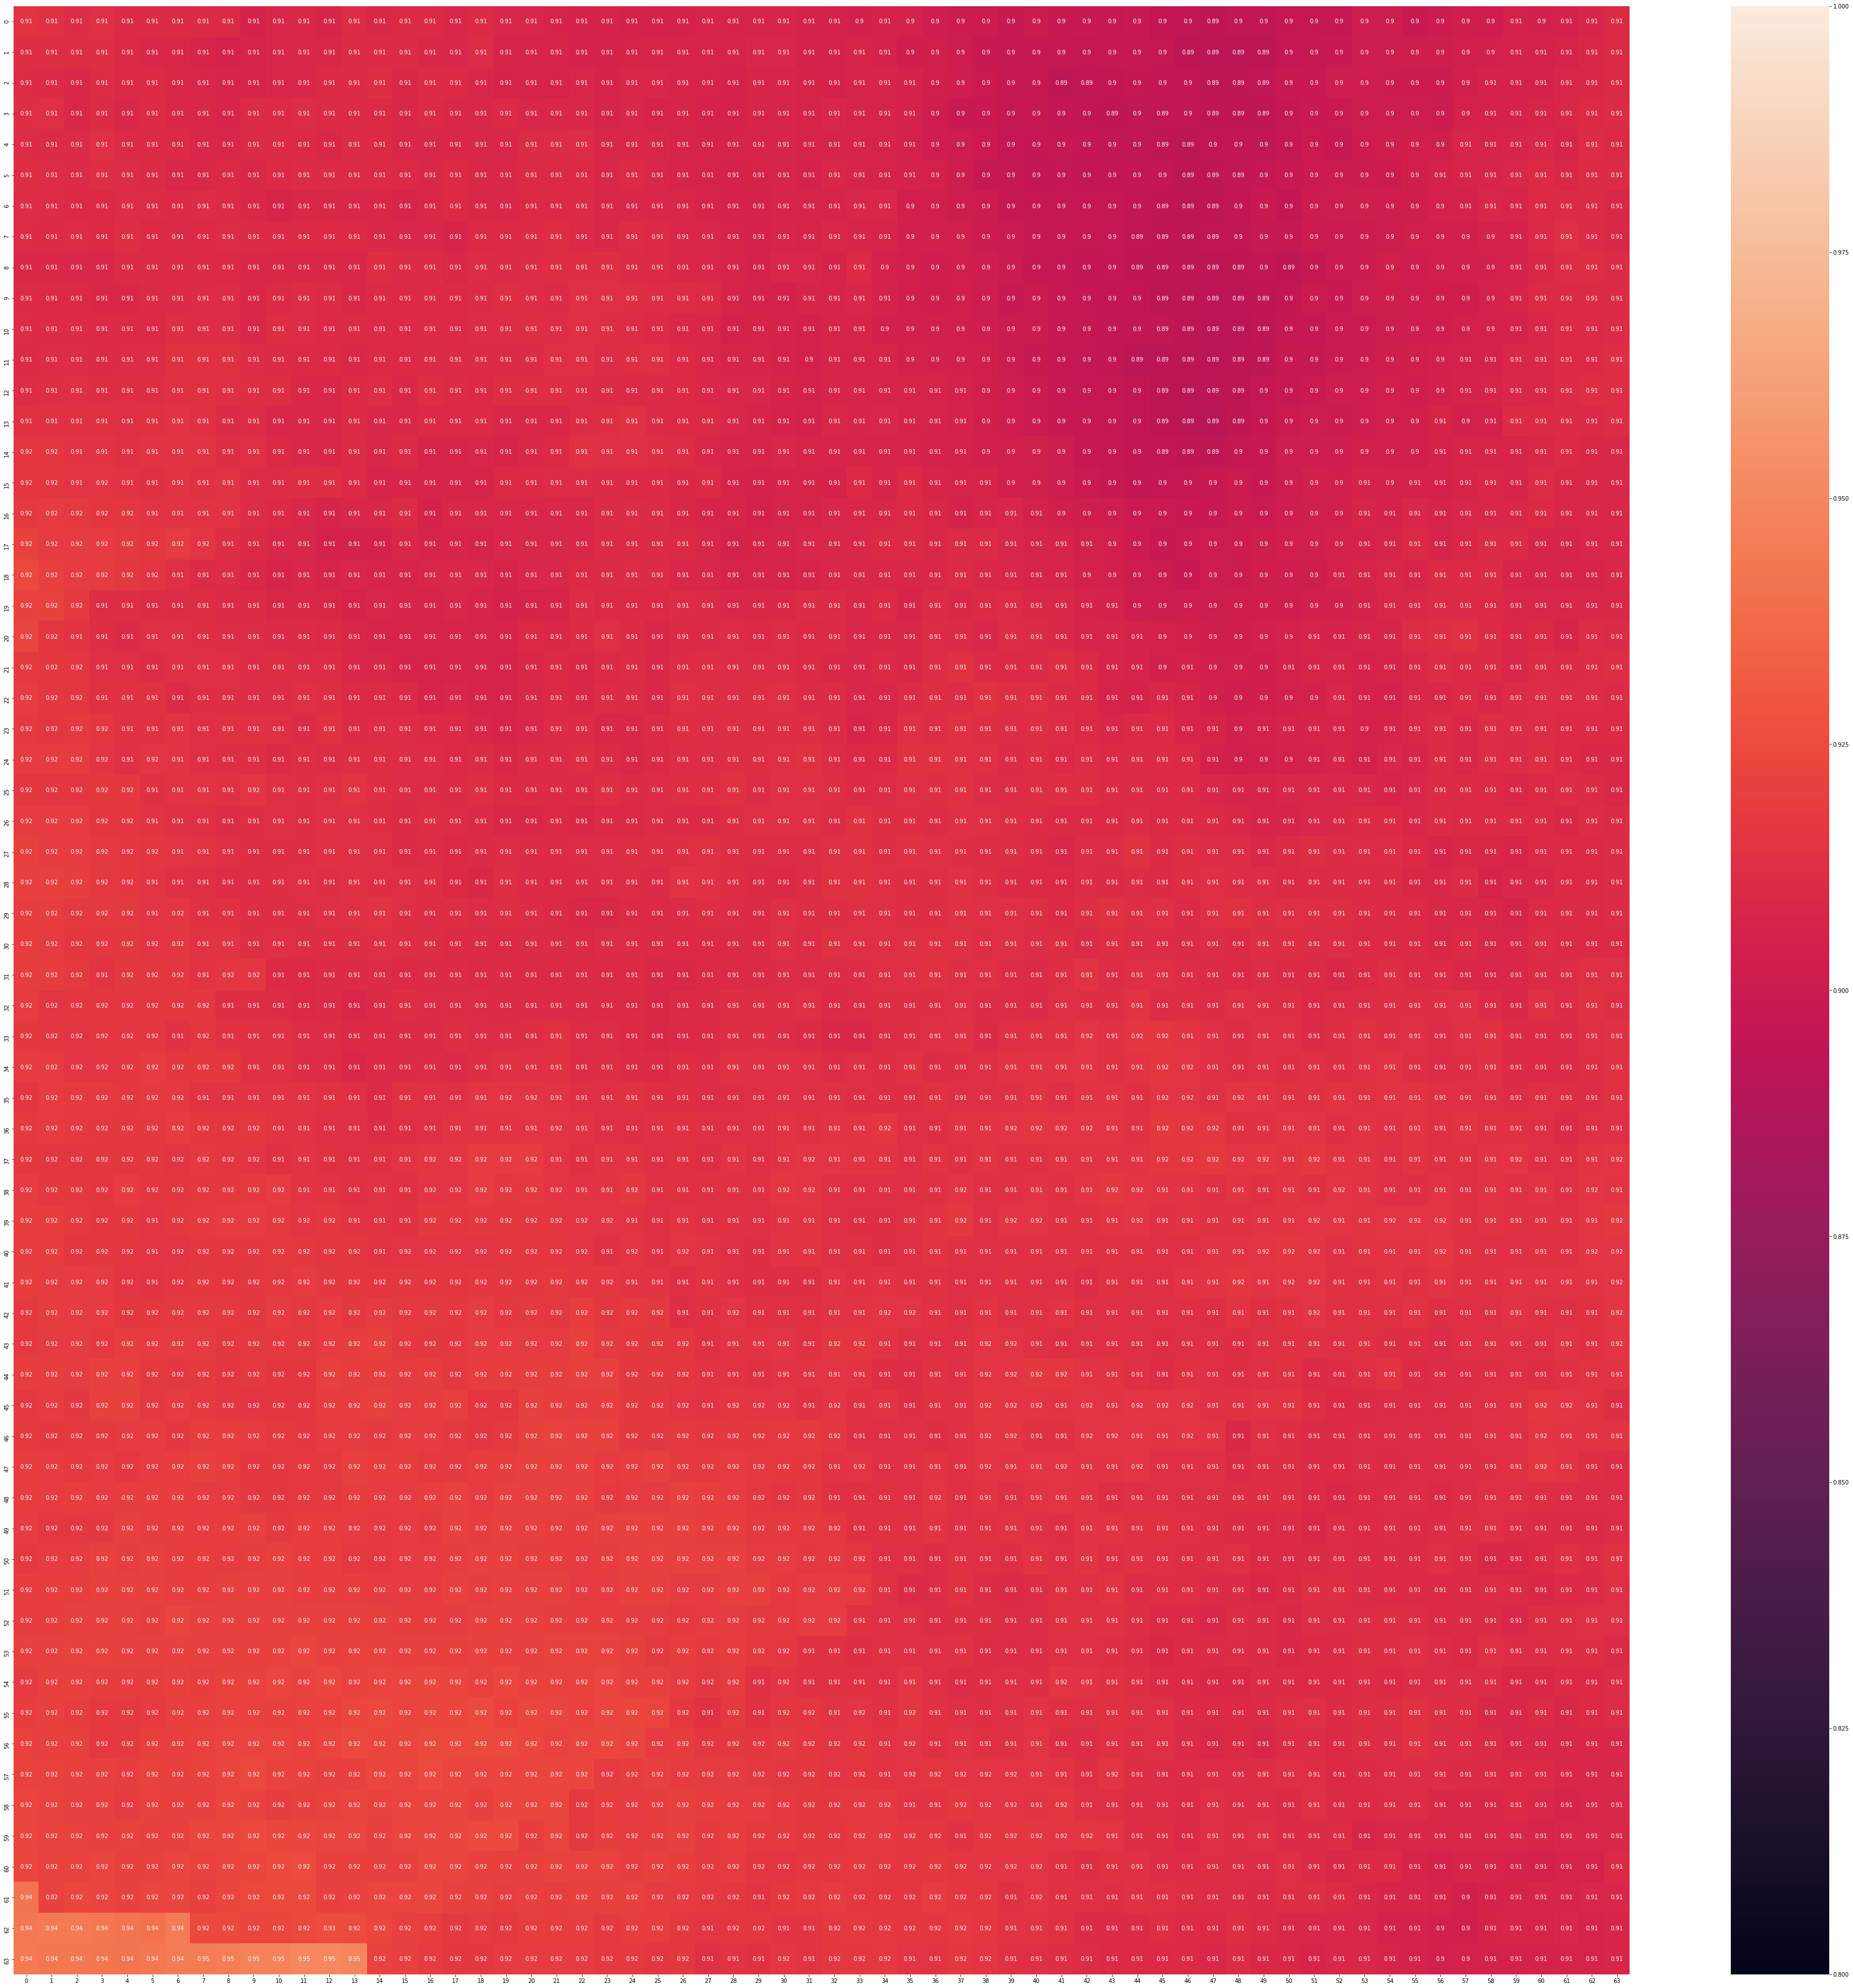

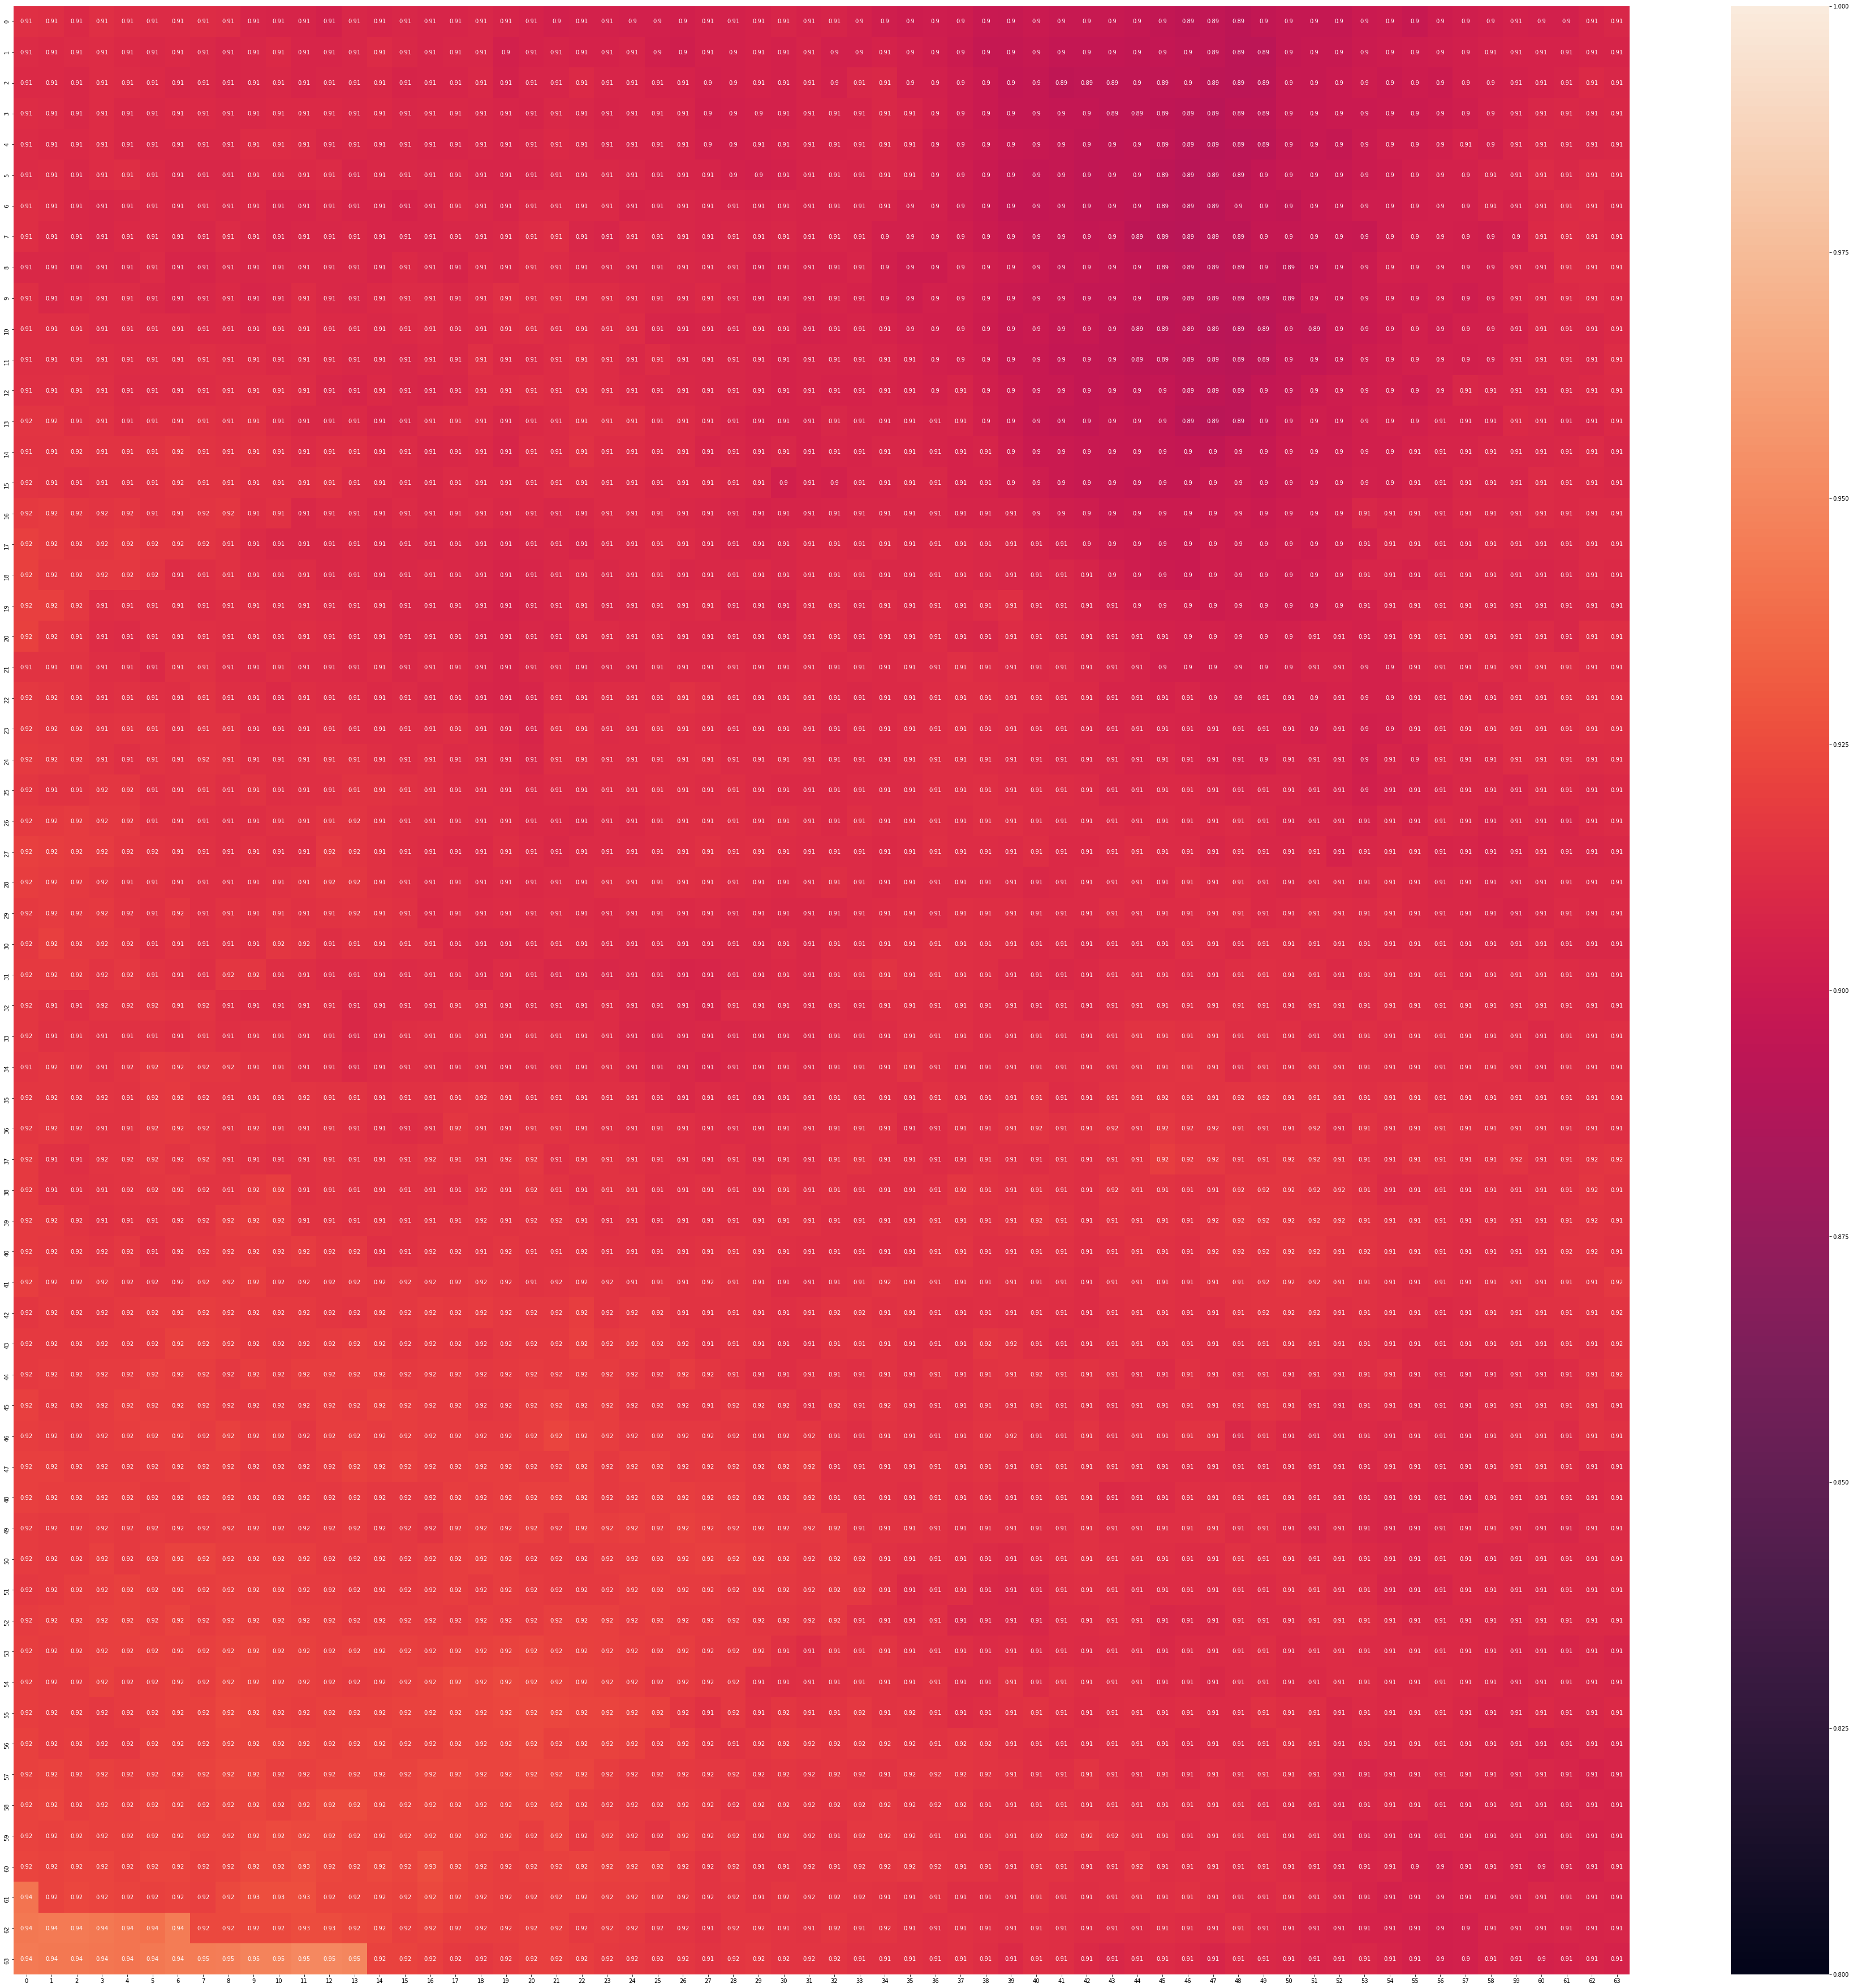

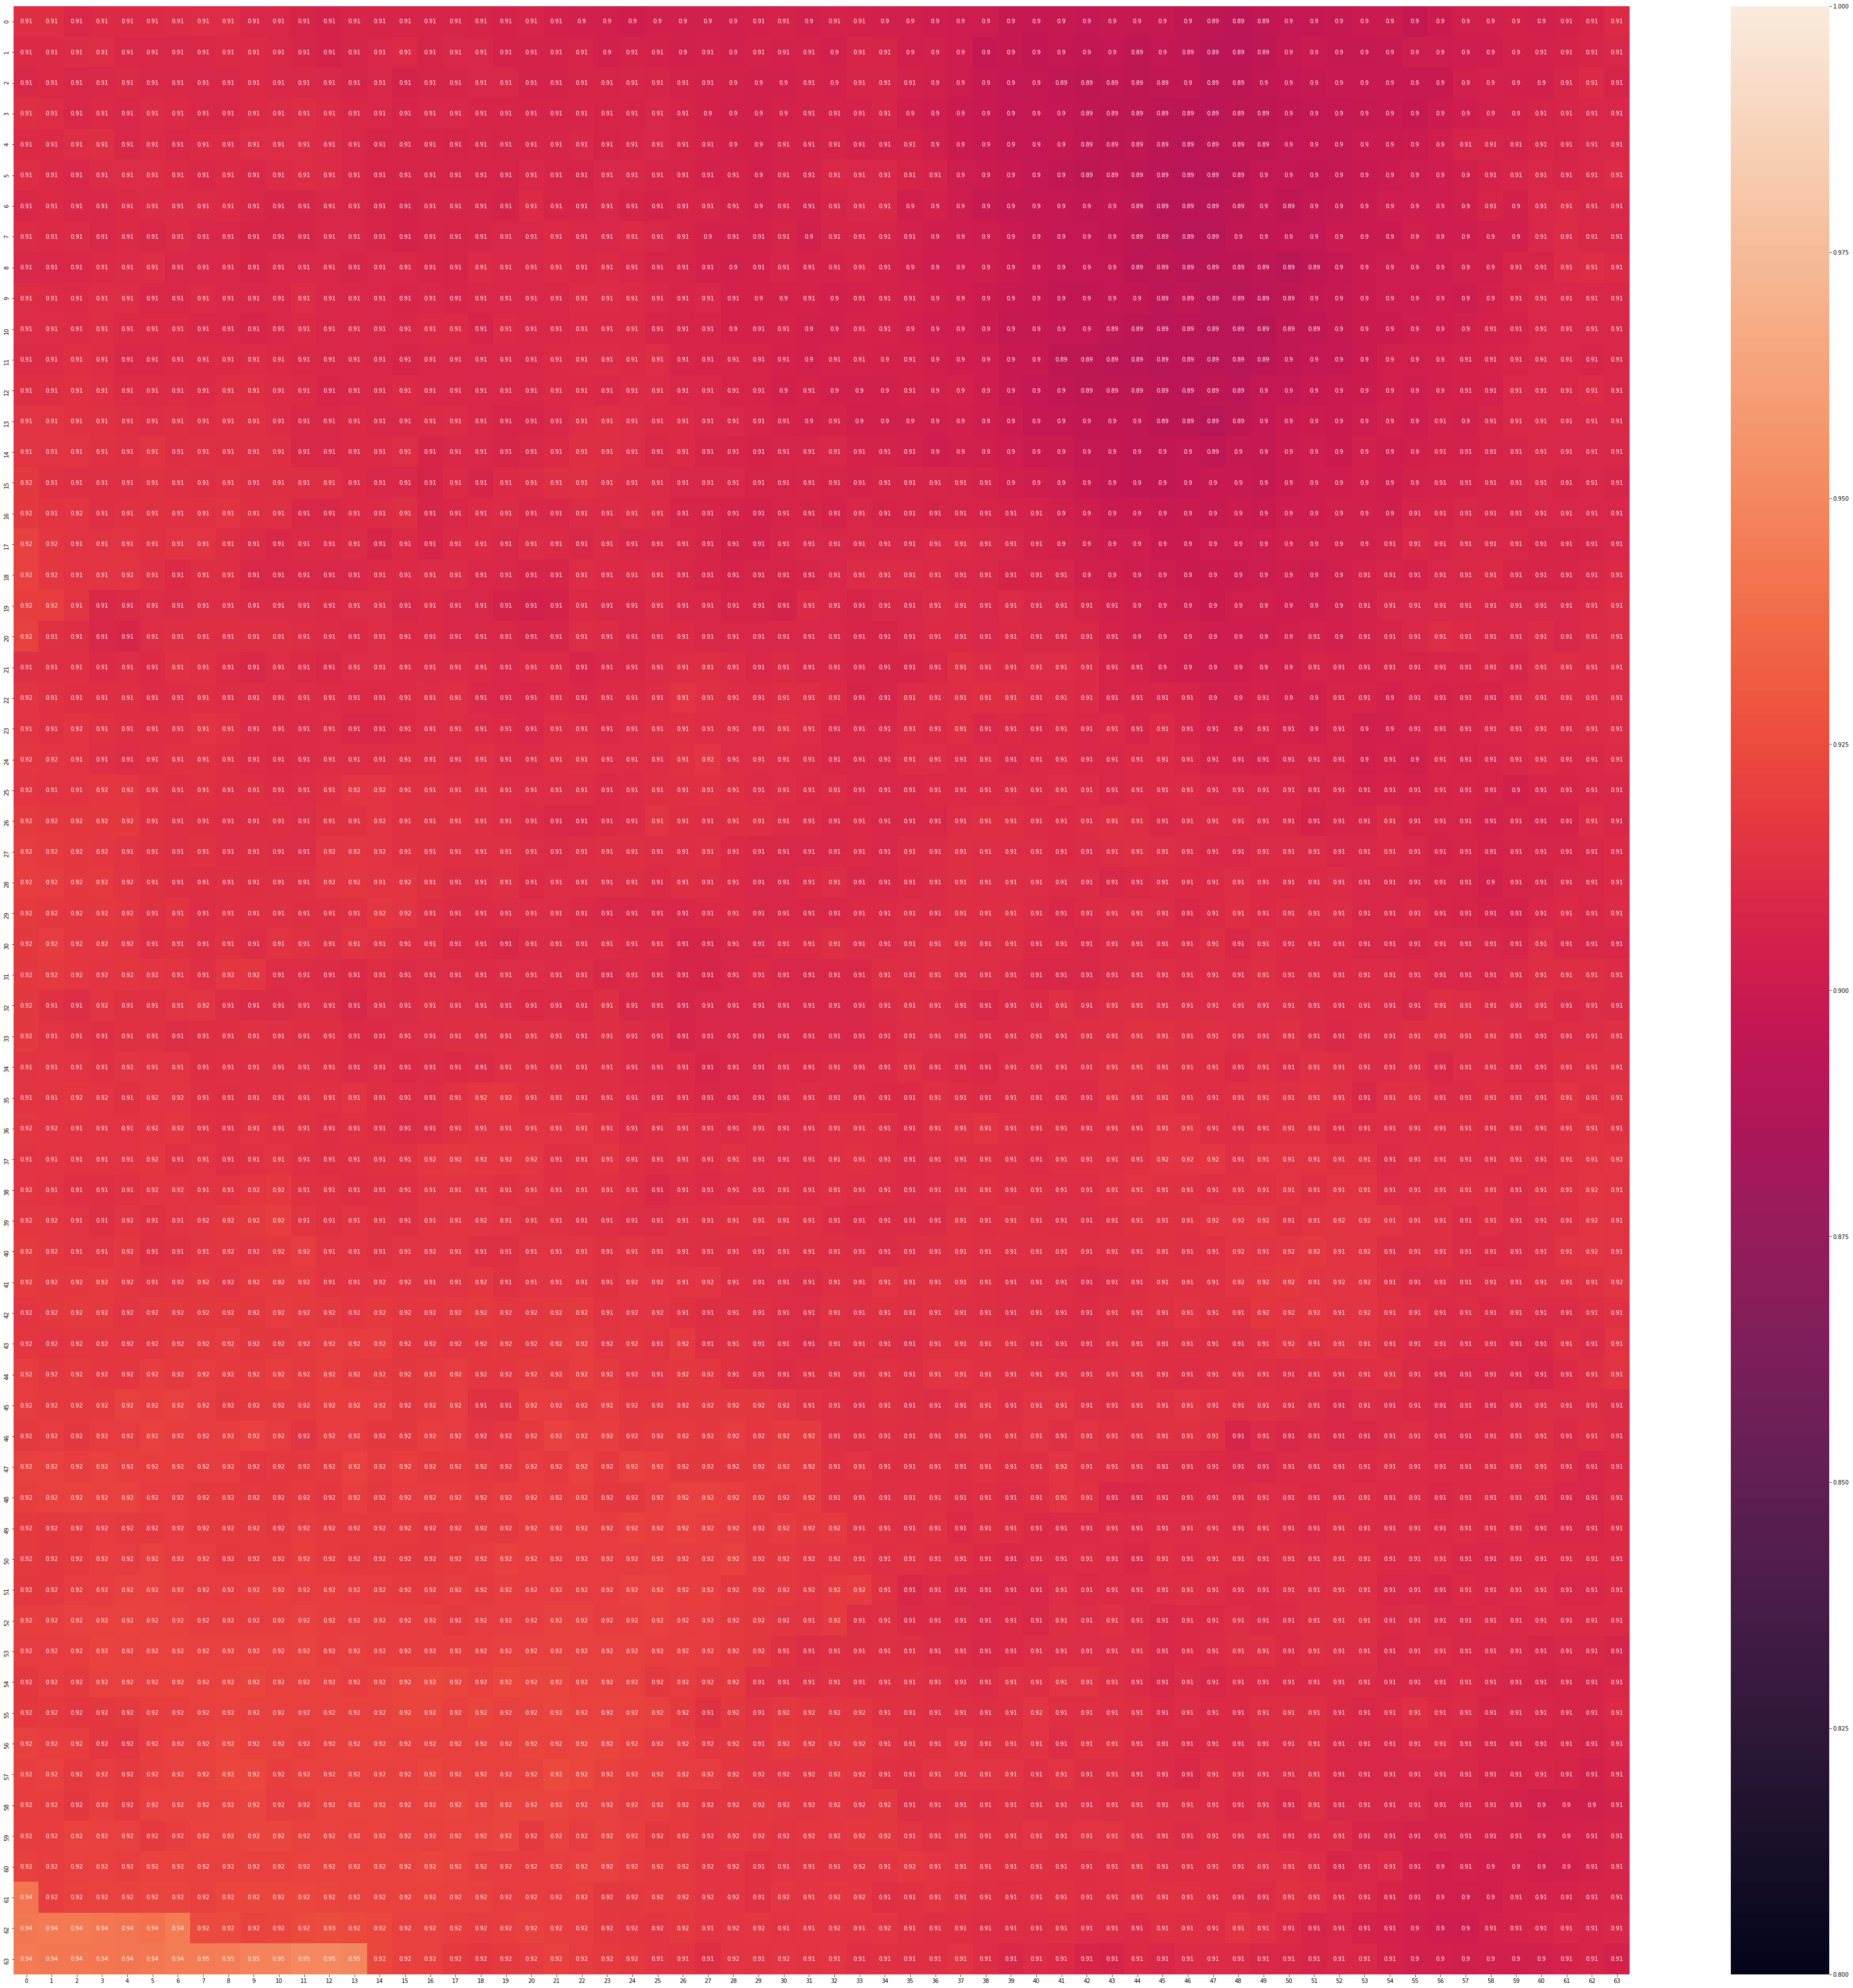

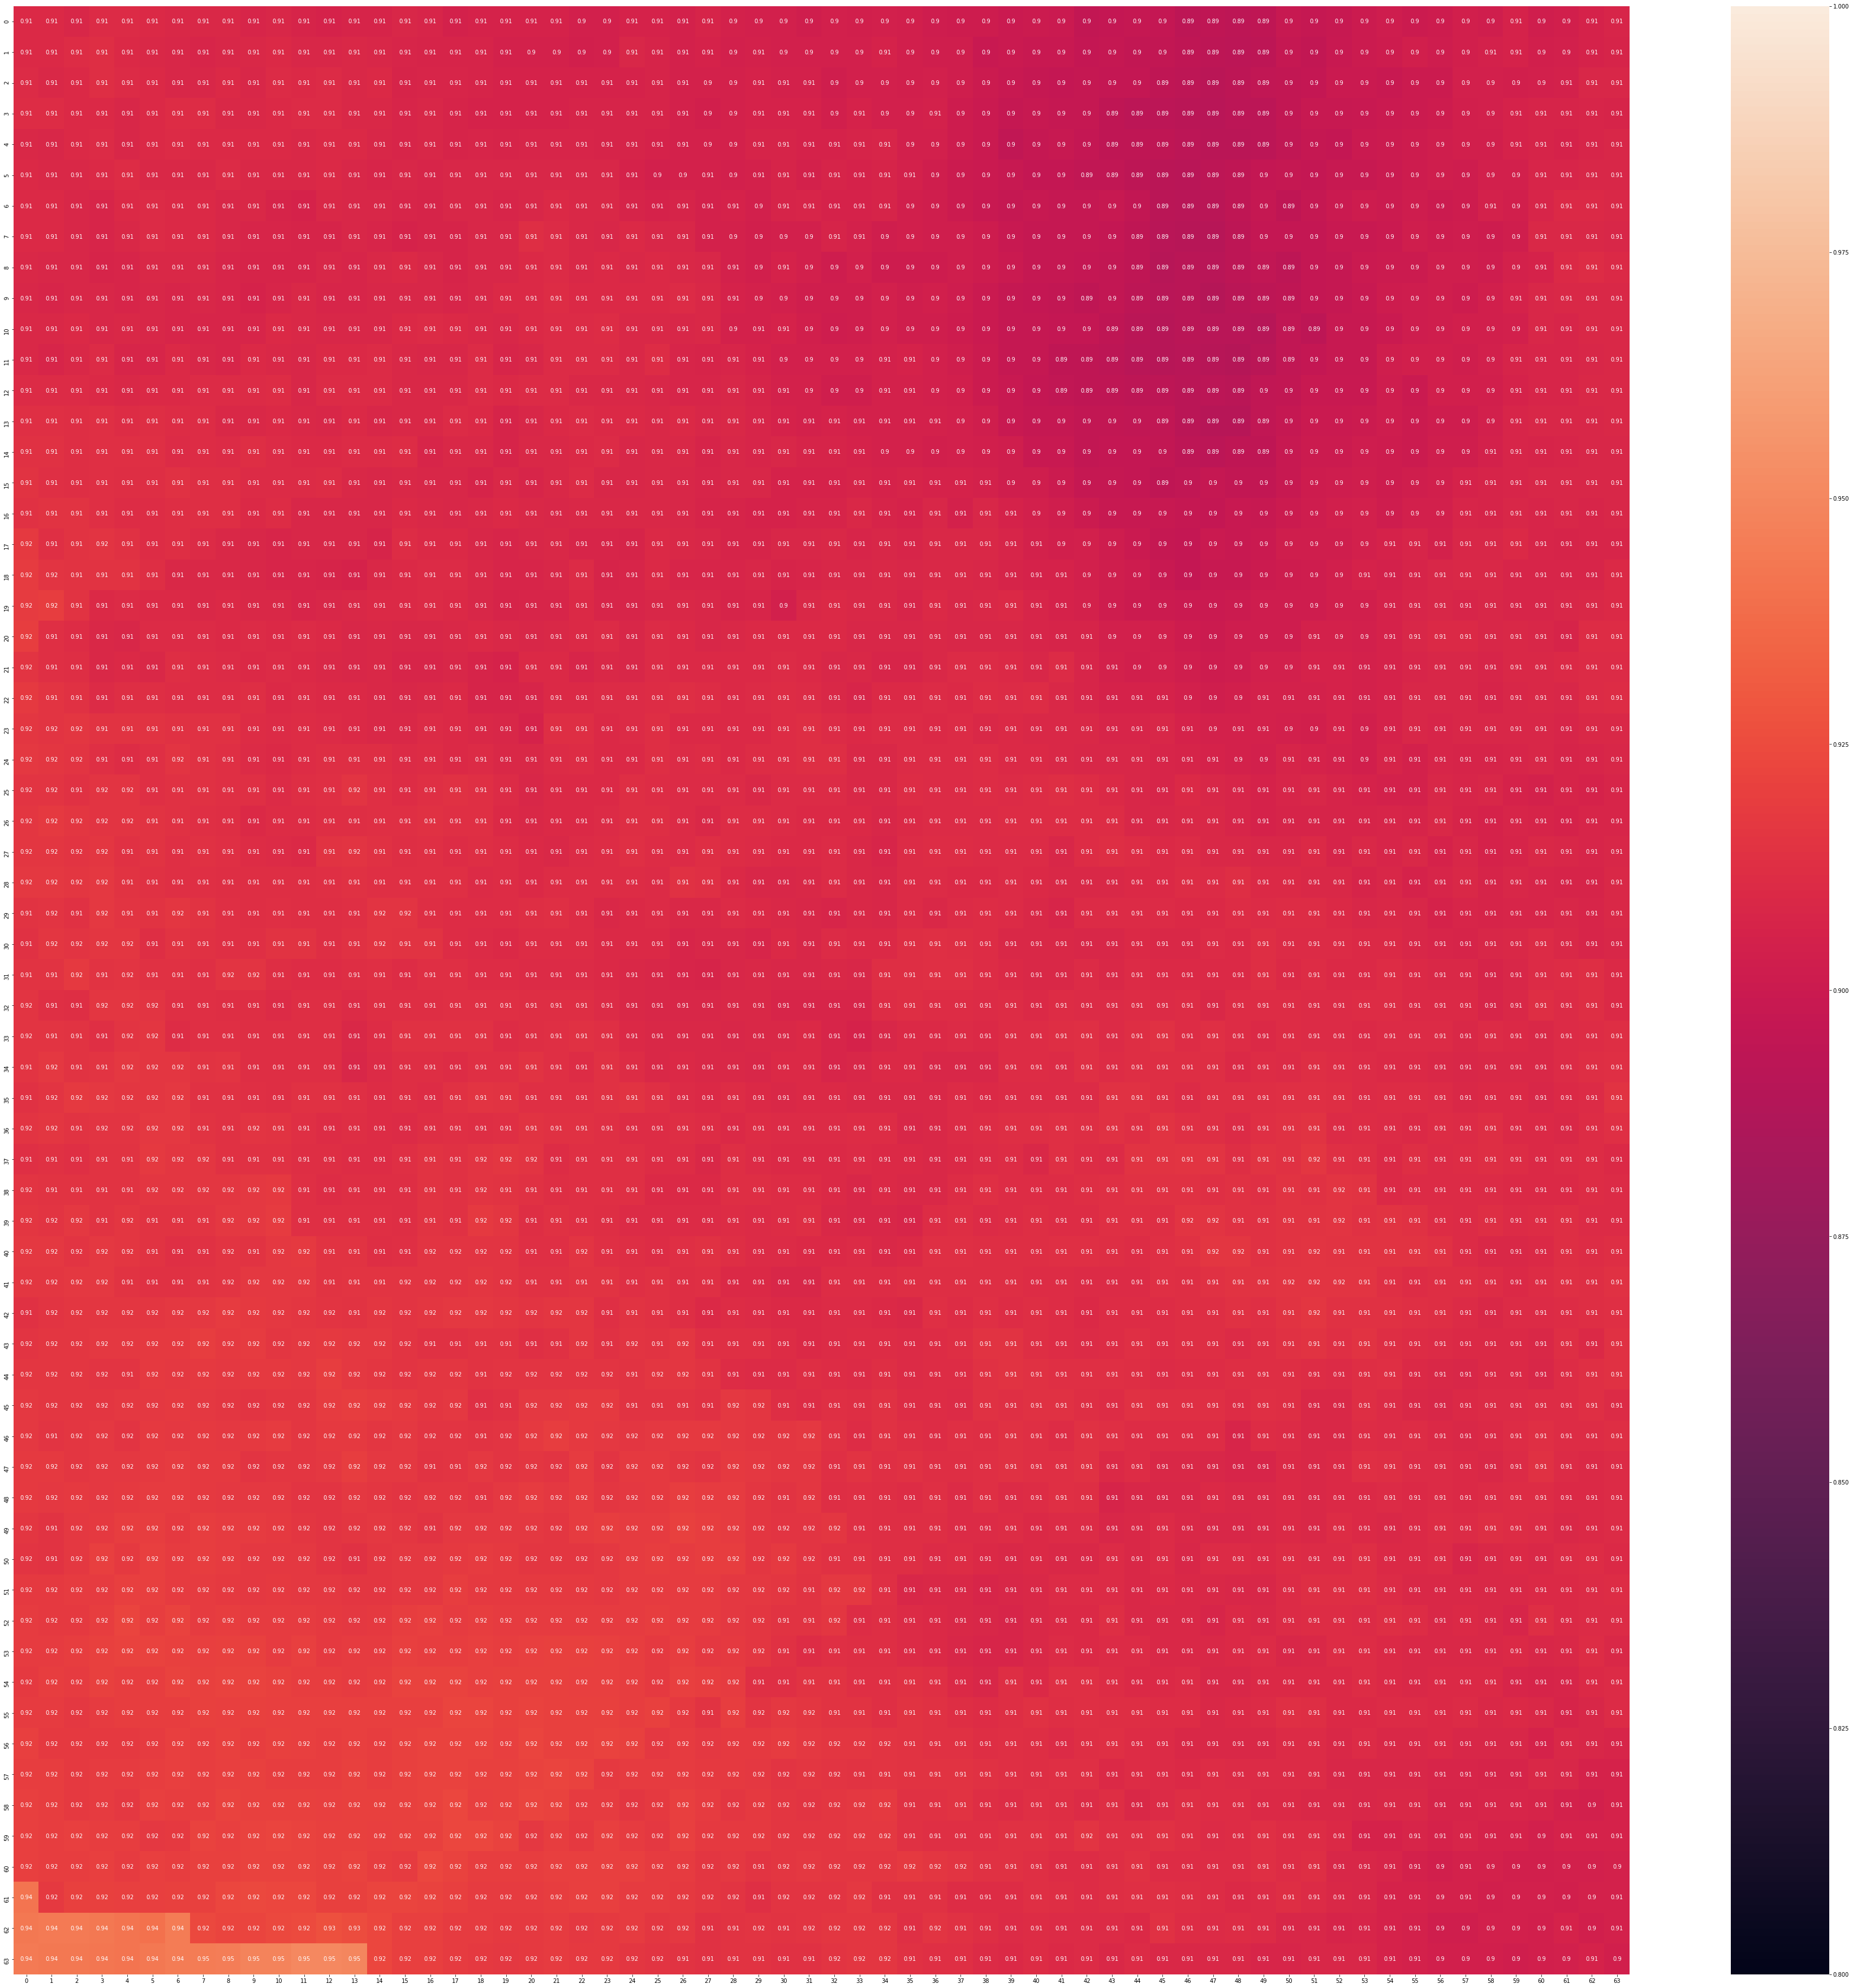

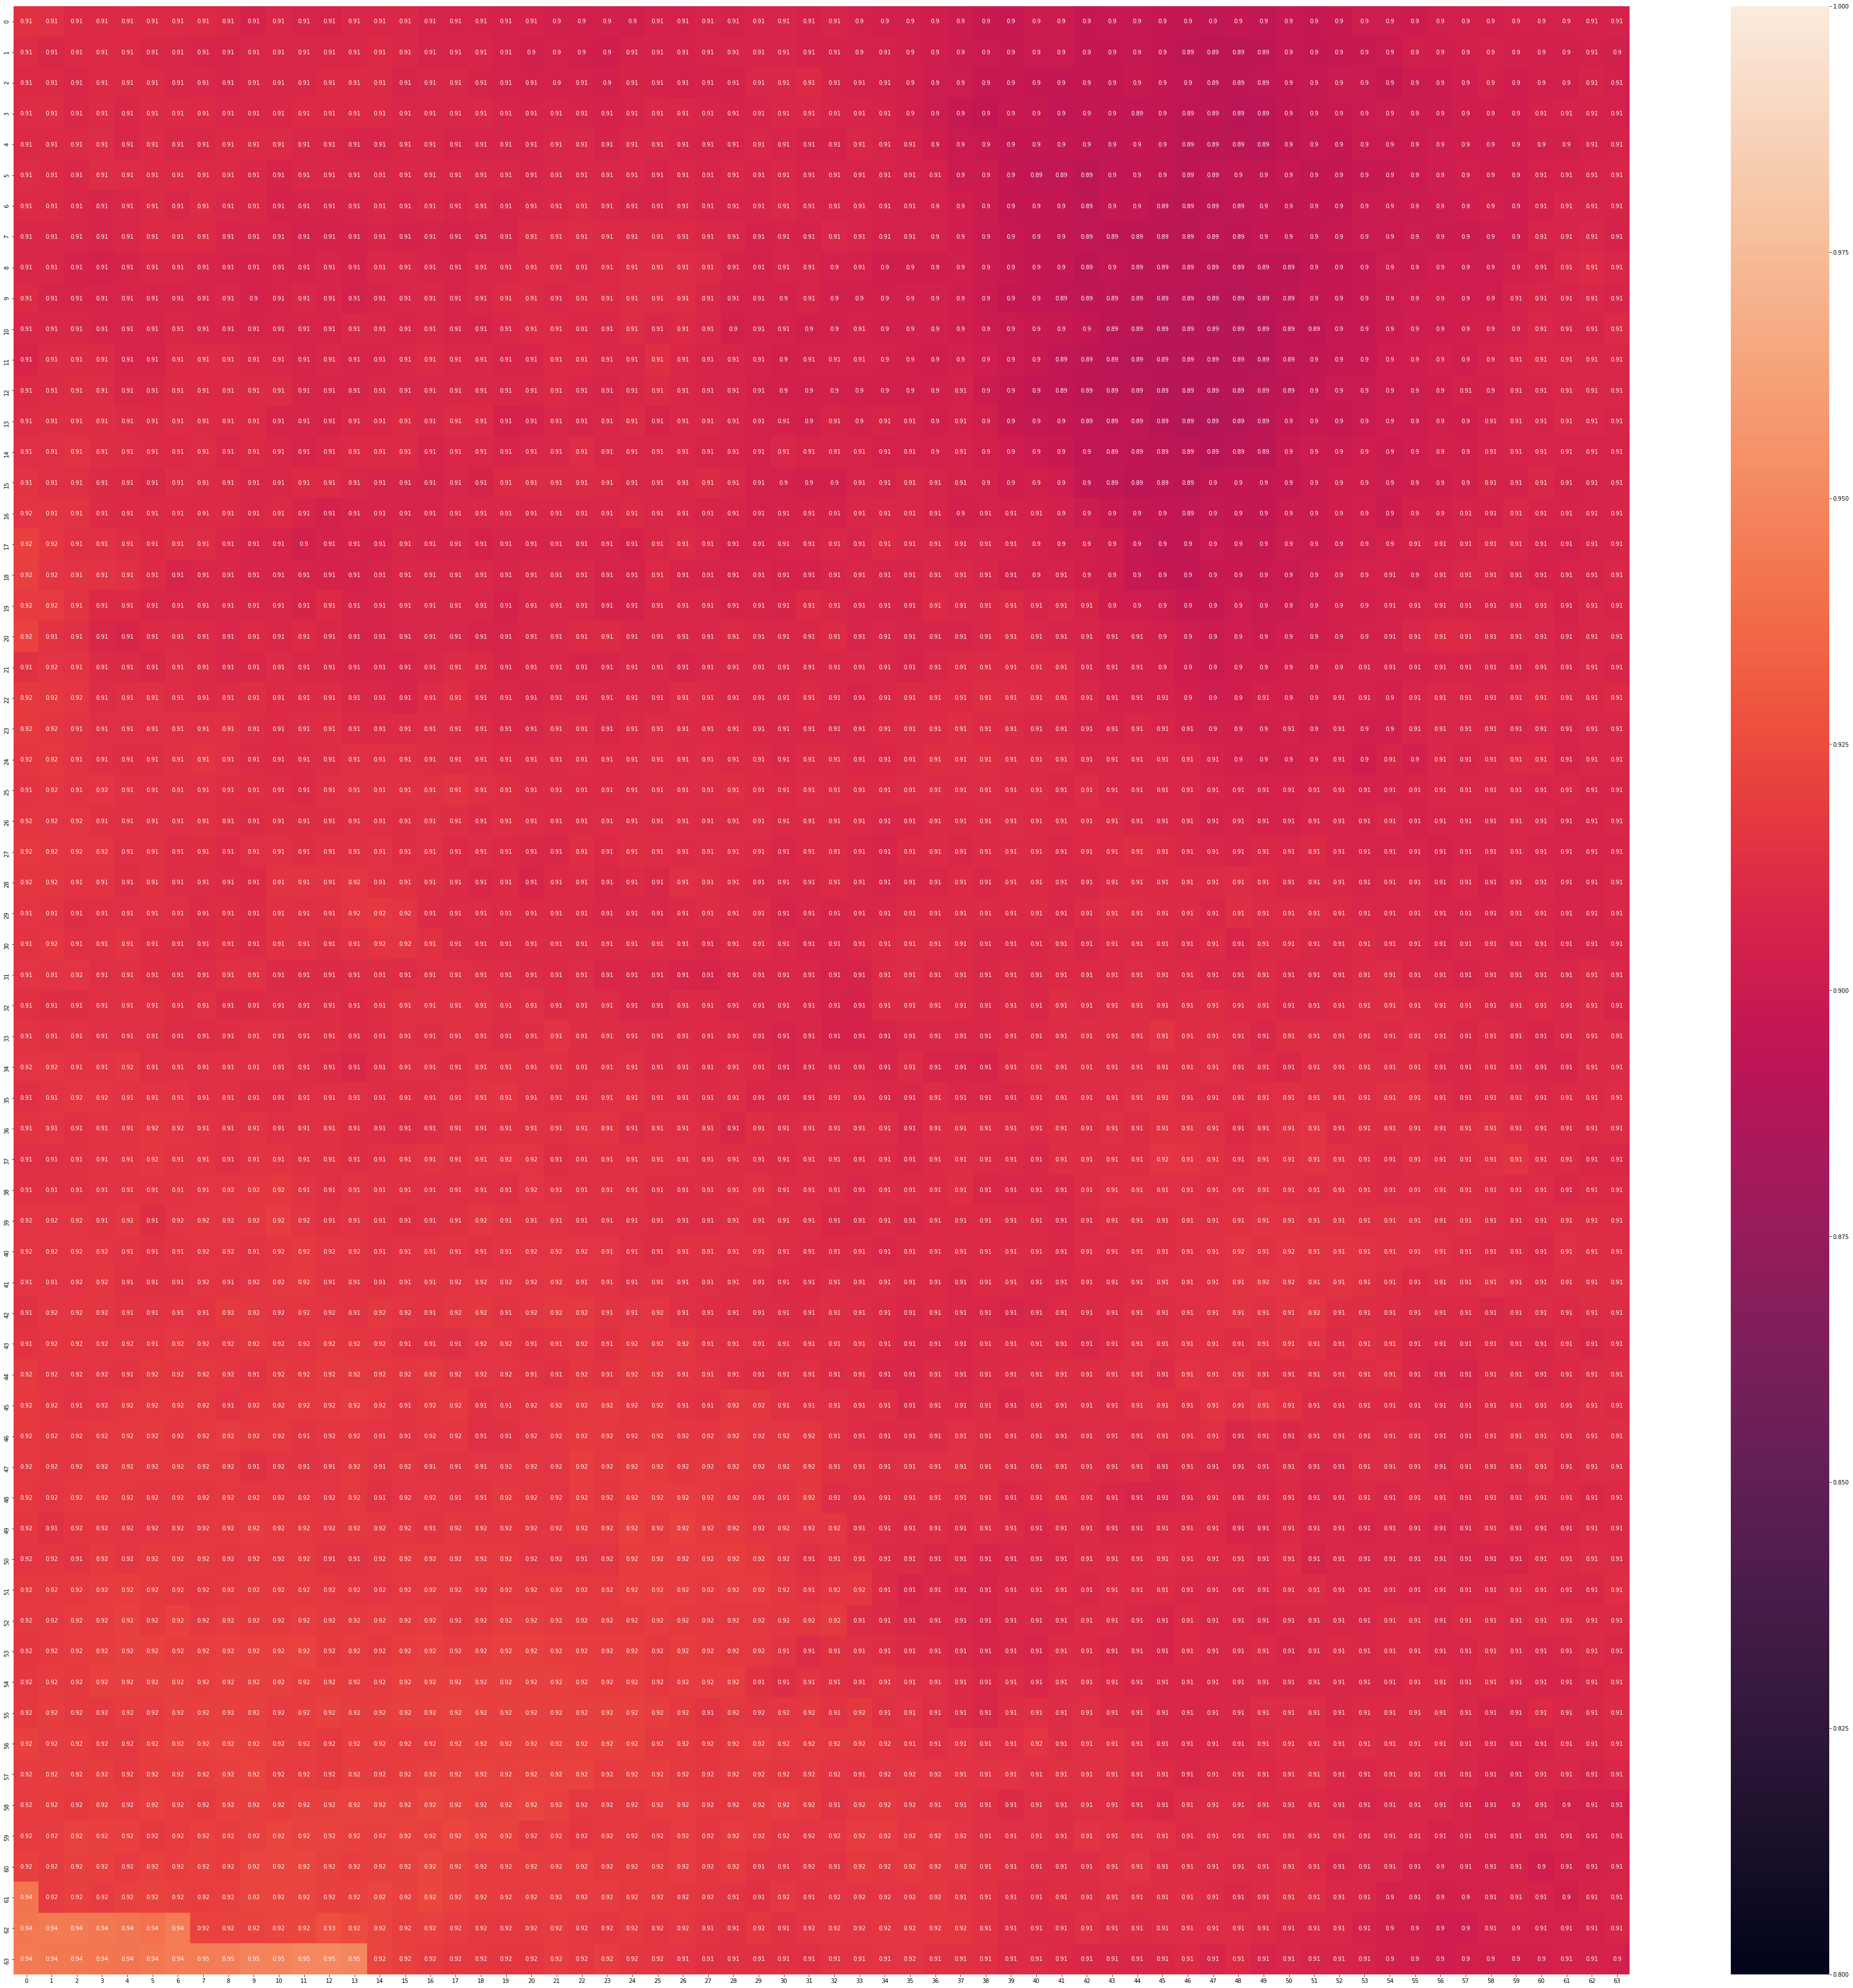

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



def plotConfusionMatrix(values):
    correct,incorrect = values
    proportion = correct / (correct+incorrect)
    x,y,t = proportion.shape
    for i in range(t):
        df_cm = pd.DataFrame(proportion[:,:,i], 
                             index = [i for i in range(x)],
                             columns = [i for i in range(x)])
        plt.figure(figsize = (64,64))
        sn.heatmap(df_cm, annot=True,vmin=0.8, vmax=1.0)
    
plotConfusionMatrix(rain_simple)

(1, 64, 64, 6)
(1, 64, 64, 6)
tf.Tensor([1.], shape=(1,), dtype=float32)
(1, 64, 64, 6)
tf.Tensor(
[[[[7.72953081e-06 1.56035239e-05 1.21766643e-05 1.98360885e-05
    2.97646839e-05 4.45547848e-05]
   [7.35114509e-06 1.50164669e-05 1.16447336e-05 1.93177275e-05
    2.99949352e-05 4.53612120e-05]
   [4.89358581e-06 8.39443419e-06 9.38408266e-06 1.13632595e-05
    1.80281131e-05 2.63265683e-05]
   ...
   [8.28576503e-06 6.38758684e-06 5.08888797e-06 8.21294543e-06
    1.64683588e-05 1.98921734e-05]
   [8.69792439e-06 6.11479481e-06 5.39181792e-06 9.31668001e-06
    1.84411565e-05 2.15148884e-05]
   [8.20251171e-06 6.19272851e-06 4.96943403e-06 8.91011496e-06
    1.66497630e-05 2.15223718e-05]]

  [[6.80314361e-06 9.83537029e-06 1.99849237e-05 1.71100291e-05
    2.76386290e-05 3.04518217e-05]
   [6.28611815e-06 1.30386115e-05 1.61669814e-05 2.00828435e-05
    4.07855041e-05 3.44340842e-05]
   [3.33924822e-06 6.56437669e-06 1.12917514e-05 1.09426082e-05
    2.02354950e-05 2.27002020e-05]
 

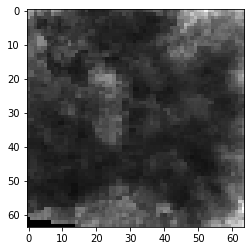

tf.Tensor([0.8144648], shape=(1,), dtype=float32)


In [78]:
#del rain_simple

def map_Dist_To_Rain(prediction):
    
    x,y,t      = prediction[0][0,:,:,:].shape
    rain_true  = np.zeros((x,y,t))
    rain_false = rain_true.copy()
    
    for pred in prediction:
        #print(pred.)
        #print(pred.sample())
        zeros = np.ones(pred.shape)
        print(pred.mean().shape)
        print(pred.shape)
        s = pred.cdf(zeros[0,:,:,:])
        s = pred.mean()
        print(pred.cdf(zeros))
        print(s.shape)
        print(s)
        #print(s[0,:,:,0])
        #print(s)
        #if np.max(s.mean()) == 0:
        #    continue
        plt.imshow(s[0,:,:,0],cmap="gray")
        plt.show()
        print(pred.cdf(0))
        #print(pred.cdf())
        break
    

map_Dist_To_Rain(prediction)

In [1]:
total_c = [[2,2,2],[3,3,3]]
prob_c = [[0.1,0.2,0.3],[0.4,0.5,0.6]]

dist_nb = tfp.distributions.NegativeBinomial(
            total_count=total_c, probs=prob_c )

dist_nbi = tfd.Independent(
    tfp.distributions.NegativeBinomial(
            total_count=total_c, probs=prob_c )
)
print(dist_nb)
print(dist_nbi)
print(dist_nb.cdf(2))
print(dist_nbi.cdf(2))

NameError: name 'tfp' is not defined